# Examples of Paired Transforms in `TorchVision 0.4`

This notebook showcases the effect of applying paired transforms on (image, ground-truth) pairs. Feel free to click on each of the links below to jump directly to each example. The last section provides you with an example on how to build a `PyTorch` dataloader making use of paired transforms:

# Table Of Contents
* [Paired Transforms](#paired_transforms)
    * [`Resize`](#resize)
    * [`CenterCrop`](#center_crop)
    * [`Pad`](#pad) 
    * [`RandomCrop`](#random_crop)
    * [`RandomApply`](#random_apply)
    * [`RandomOrder`](#random_order)
    * [`RandomChoice`](#random_choice)
    * [`RandomHorizontalFlip`](#random_horizontal_flip)
    * [`RandomVerticalFlip`](#random_vertical_flip)
    * [`RandomResizedCrop`](#random_resized_crop)
    * [`FiveCrop`](#five_crop)
    * [`TenCrop`](#ten_crop)
    * [`RandomRotation`](#random_rotation)
    * [`RandomAffine`](#random_affine)    
    * [`RandomPerspective`](#random_perspective)
    * [`Compose`](#compose)
    * [`ToTensor`](#to_tensor)
    * [`ToPILImage`](#to_PILimage)
* [Unpaired transforms](#non_paired_transforms)
    * [`ColorJitter`](#color_jitter)
    * [`Grayscale`](#grayscale)
    * [`RandomGrayscale`](#random_grayscale)    
    * [`Lambda`](#lambda)    
* [Operations on Tensor (Unpaired)](#on_tensors)    
    * [`Normalize`](#normalize)
    * [`RandomErasing`](#random_erasing)
    * [`LinearTransformation`](#linear_transformation)
* [Example: Building a Dataloader with Paired Transforms](#example)  
    * [`Dataset`](#dataset)
    * [`DataLoader`](#dataloader)

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2

import paired_transforms_tv04 as p_tr

In [2]:
# load image and labels with PIL
image = Image.open('images/luppo_and_more.png') # PIL image in [0,255], 3 channels
gdt = Image.open('images/labels.png') # PIL image in {0,255}, 3 channels

In [3]:
def imshow_pair(im, gdt):
    f, ax = plt.subplots(1, 2, figsize=(12,6))
    np_im = np.asarray(im)
    np_gdt = np.asarray(gdt)
    if len(np_im.shape) == 2:
        ax[0].imshow(np_im, cmap='gray'),  ax[0].axis('off')
    else:
        ax[0].imshow(np_im),  ax[0].axis('off')
    if len(np_gdt.shape) == 2:
        ax[1].imshow(np.asarray(gdt), cmap = 'gray'), ax[1].axis('off')
    else:
        ax[1].imshow(np.asarray(gdt)), ax[1].axis('off')
    plt.tight_layout()

In [4]:
def imshow_pair_list(im_l, gdt_l):
    n_pairs = len(im_l)
    f, ax = plt.subplots(2, n_pairs, figsize=(n_pairs*n_pairs, 2*n_pairs))
    for i in range(n_pairs):
        ax[0, i].imshow(np.asarray(im_l[i])),  ax[0,i].axis('off') 
        ax[1, i].imshow(np.asarray(gdt_l[i]), cmap='gray'), ax[1,i].axis('off') 
    plt.tight_layout()

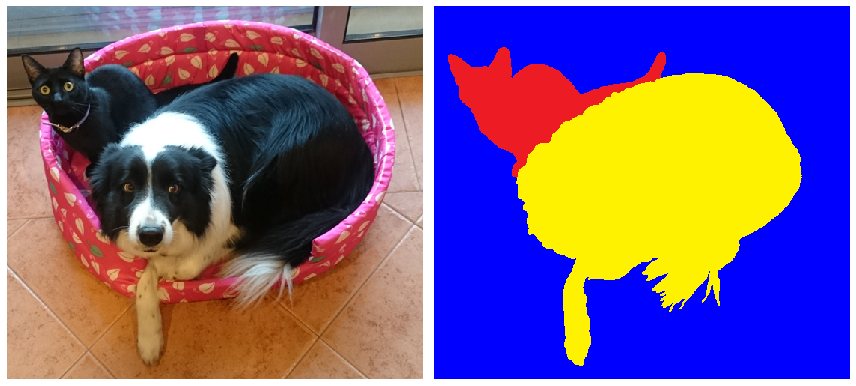

In [5]:
imshow_pair(image, gdt)

### Important Note:
The above example contains a target image encoded by color, each differnt color represents a different label. Loss computation in `pytorch` often requires a different format, a grayscale image where each label is assigned a different integer in `[0, 1, 2, ..., nb_classes]`. A reasonable way of mapping the color-encoded labels to a grayscale image is as follows:

In [6]:
gdt_gray = np.array(gdt.convert('L'))
label_values = np.unique(gdt_gray) # find out how many different colors are (in grayscale)
label_values

array([ 29,  91, 218], dtype=uint8)

In [7]:
classes = np.arange(len(label_values))
for i in classes:
    gdt_gray[gdt_gray==label_values[i]]=classes[i]
np.unique(gdt_gray) # check correct label values

array([0, 1, 2], dtype=uint8)

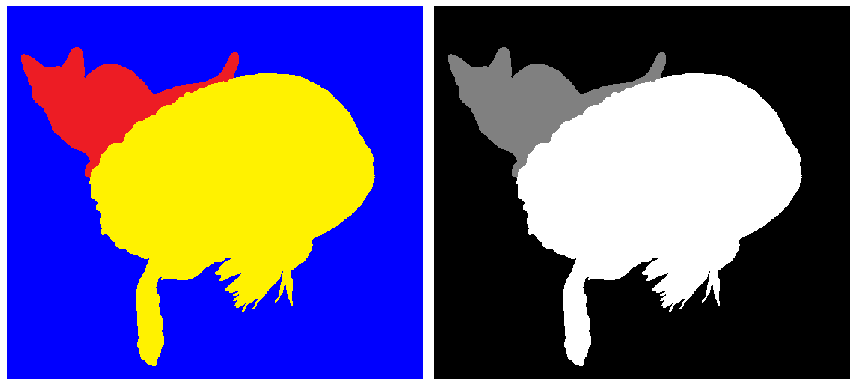

In [8]:
imshow_pair(gdt, gdt_gray)

Now, it may happen that not all your target images contain pixels belonging to all classes. For this reason, it might be better to run the above code once on an image that has all classes represented in order to obtain a "universal" `label_values` array. That array could then be supplied afterwards to a function performing the transformation as above:

In [9]:
label_values = np.unique(gdt.convert('L'))

def encode_labels(gdt, label_values):
    gdt_gray = np.array(gdt.convert('L'))
    classes = np.arange(len(label_values))
    for i in classes:
        gdt_gray[gdt_gray==label_values[i]]=classes[i]
    return Image.fromarray(gdt_gray)

In [12]:
new_gdt = encode_labels(gdt, label_values)
np.unique(new_gdt)

array([0, 1, 2], dtype=uint8)

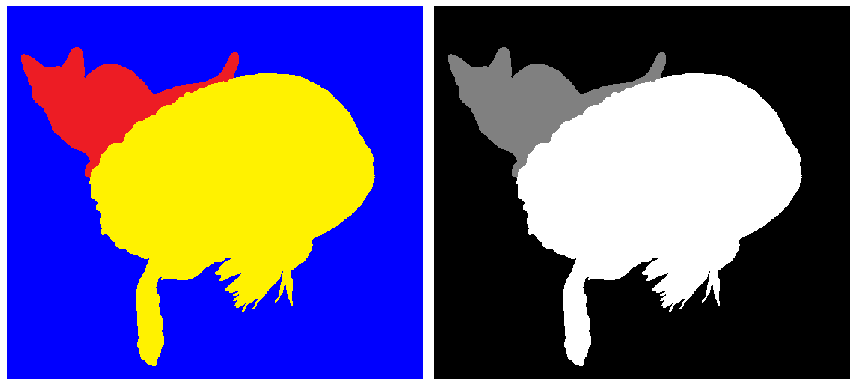

In [13]:
imshow_pair(gdt, new_gdt)

All the examples below are run on this kind of grayscale label images. Also, if you want to skip all this and see directly an example of how to create a `pytorch` dataset/dataloader, feel free to jump [here](example).

<a id='paired_transforms'></a>

# Pairable Transforms
Below we go throgh all the different classes that have been extended to handle two inputs.
<a id='resize'></a>

## `Resize()`

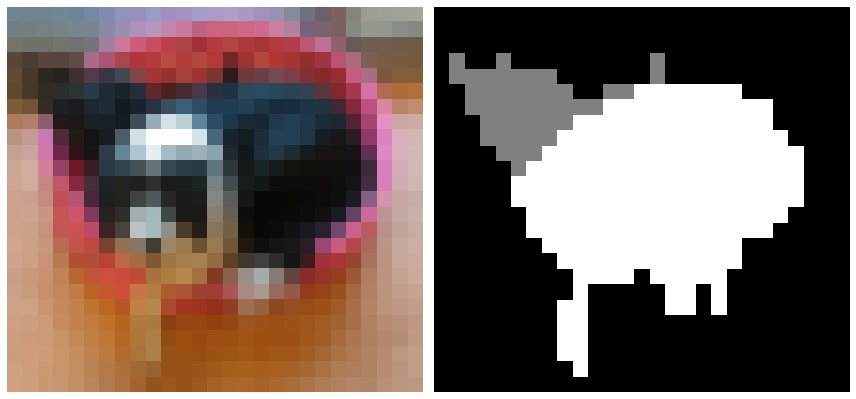

In [14]:
resize_paired = p_tr.Resize(25)
resized_pair = resize_paired(image, new_gdt)
imshow_pair(*resized_pair)

Note that we implement nearest neighbor interpolation in the groundtruth and bicubic in the image.
<a id='center_crop'></a>

## `CenterCrop()`

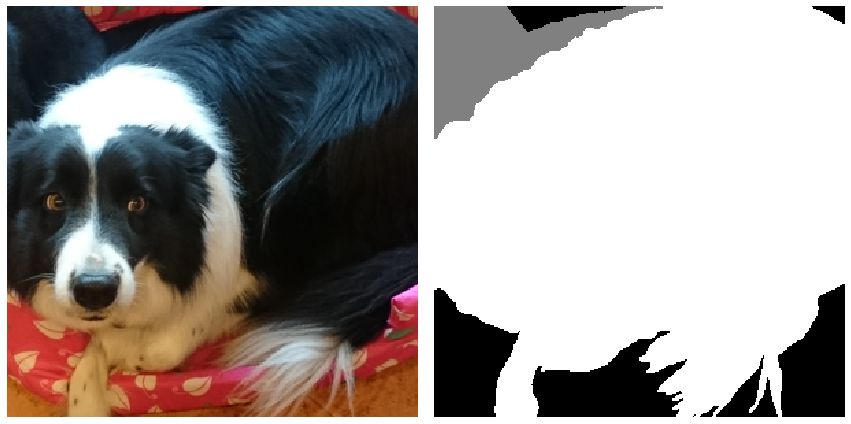

In [15]:
center_crop_paired = p_tr.CenterCrop(300)
center_cropped_pair = center_crop_paired(image, new_gdt)
imshow_pair(*center_cropped_pair)

<a id='pad'></a>

## `Pad()`
**Warning**: One has to be careful with the way of handling `Pad()`, as it can easily create artificial (black) labels, see above.

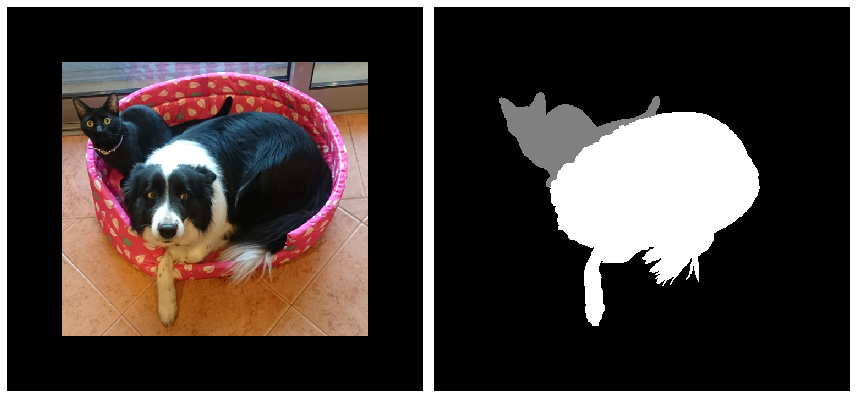

In [16]:
pad_paired = p_tr.Pad(100)
padded_pair = pad_paired(image, new_gdt)
imshow_pair(*padded_pair)

In [17]:
np.unique(padded_pair[1])

array([0, 1, 2], dtype=uint8)

Probably the safest way to pad images and labels without incurring in inconsistencies if by specifying a different `padding_mode`:

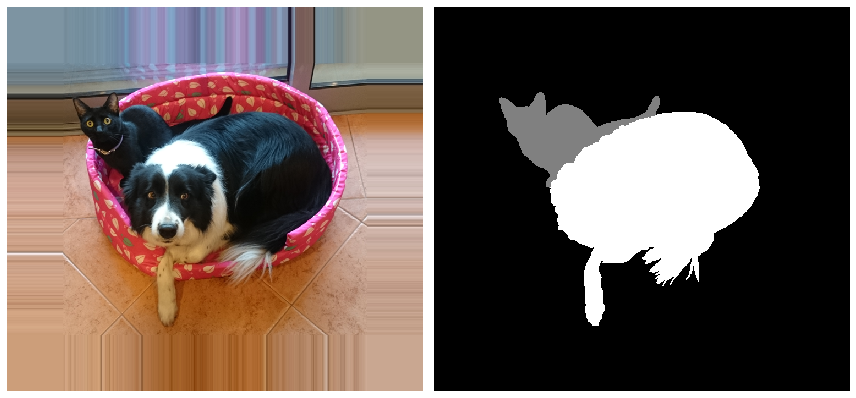

In [18]:
pad_paired = p_tr.Pad(100, padding_mode='edge')
padded_pair = pad_paired(image, new_gdt)
imshow_pair(*padded_pair)

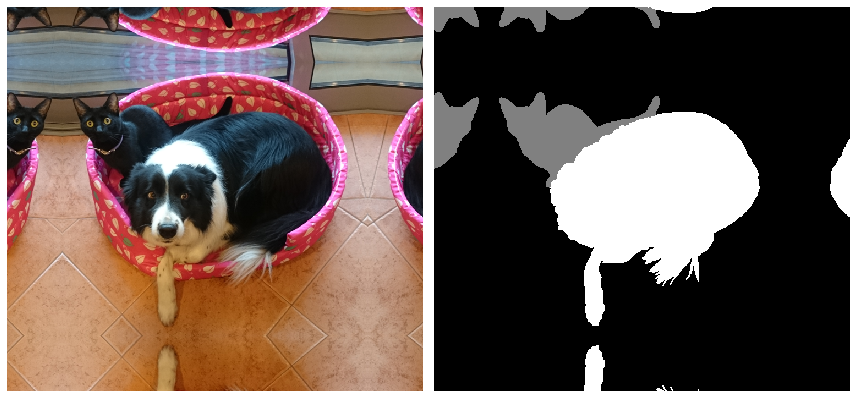

In [19]:
pad_paired = p_tr.Pad(100, padding_mode='reflect')
padded_pair = pad_paired(image, new_gdt)
imshow_pair(*padded_pair)

<a id='random_apply'></a>

## `RandomApply()`

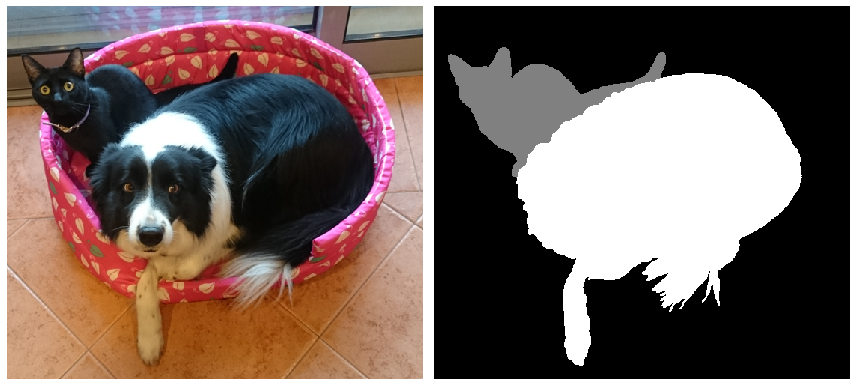

In [20]:
resize_paired = p_tr.Resize(50)
center_crop_paired = p_tr.CenterCrop(300)
random_apply_paired = p_tr.RandomApply([center_crop_paired, resize_paired], p=0.5)

randomly_transformed_pair = random_apply_paired(image, new_gdt) # run several times to see random outputs
imshow_pair(*randomly_transformed_pair)

<a id='random_order'></a>

## `RandomOrder()`

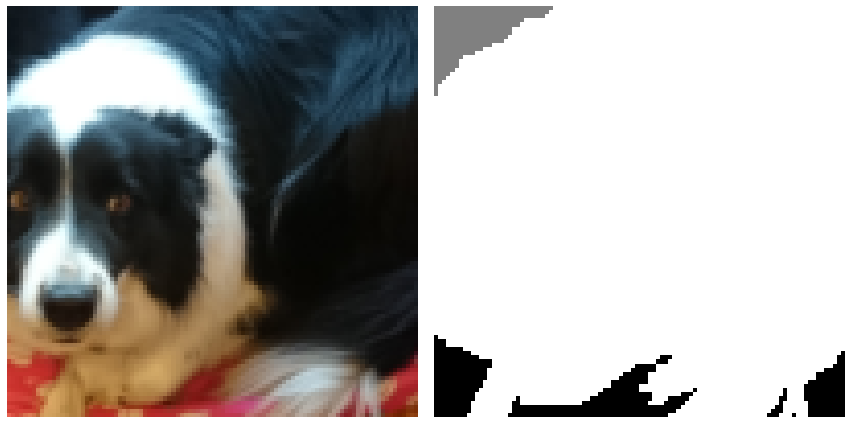

In [24]:
resize_paired = p_tr.Resize(200)
center_crop_paired = p_tr.CenterCrop(100)
random_order_paired = p_tr.RandomOrder([center_crop_paired, resize_paired]) # first crop or first resize

randomly_transformed_pair = random_order_paired(image, new_gdt) # run several times to see random outputs
imshow_pair(*randomly_transformed_pair)

<a id='random_choice'></a>

## `RandomChoice()`

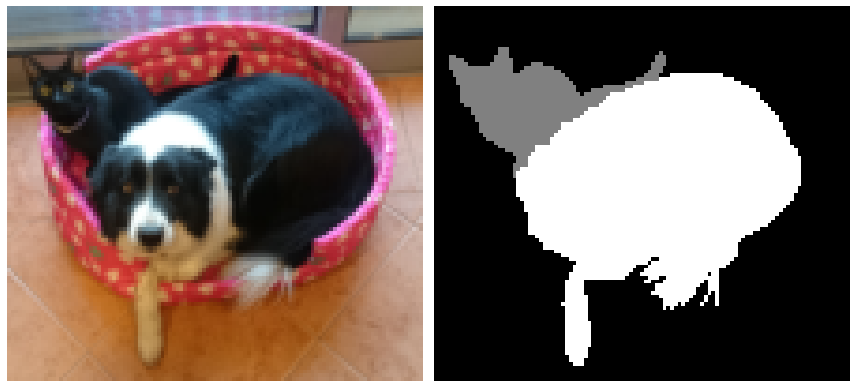

In [25]:
resize_paired = p_tr.Resize(100)
center_crop_paired = p_tr.CenterCrop(200)
random_choice_paired = p_tr.RandomChoice([center_crop_paired, resize_paired]) # either crop or resize

randomly_transformed_pair = random_choice_paired(image, new_gdt) # run several times to see random outputs
imshow_pair(*randomly_transformed_pair)

<a id='random_crop'></a>

## `RandomCrop()`

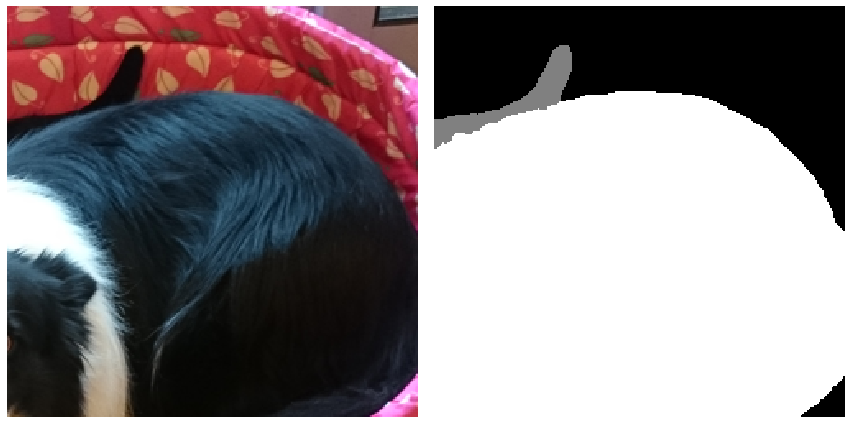

In [26]:
random_crop_paired = p_tr.RandomCrop(250)
random_cropped_pair = random_crop_paired(image, new_gdt)
imshow_pair(*random_cropped_pair)

<a id='random_horizontal_flip'></a>

## `RandomHorizontalFlip()`

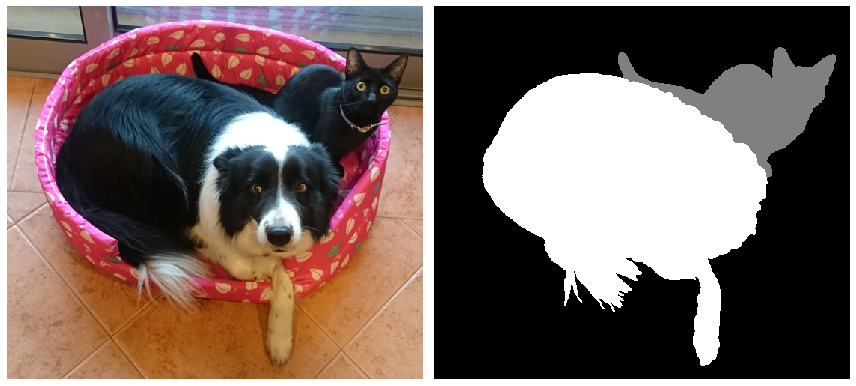

In [32]:
random_hor_flip_paired = p_tr.RandomHorizontalFlip()
random_flipped_pair = random_hor_flip_paired(image, new_gdt)
imshow_pair(*random_flipped_pair)

<a id='random_vertical_flip'></a>

## `RandomVerticalFlip()`

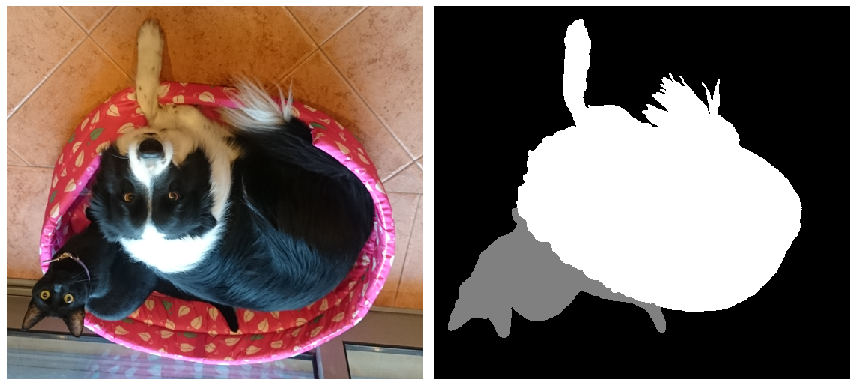

In [33]:
random_ver_flip_paired = p_tr.RandomVerticalFlip()
random_flipped_pair = random_ver_flip_paired(image, new_gdt)
imshow_pair(*random_flipped_pair)

<a id='random_perspective'></a>

## `RandomPerspective()`
(Again, one has to be careful when using this transform due to new (black) labels being created in empty spaces)

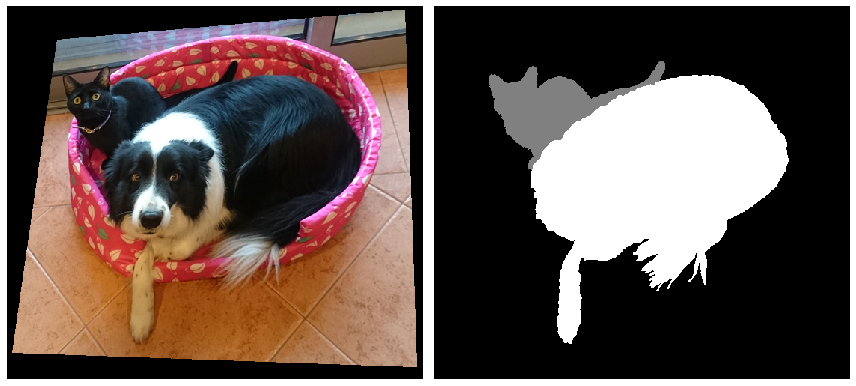

In [34]:
random_perspective_paired = p_tr.RandomPerspective(distortion_scale=0.25, p=1)
random_perspective_transformed_pair = random_perspective_paired(image, new_gdt)
imshow_pair(*random_perspective_transformed_pair)

<a id='random_resized_crop'></a>

## `RandomResizedCrop()`

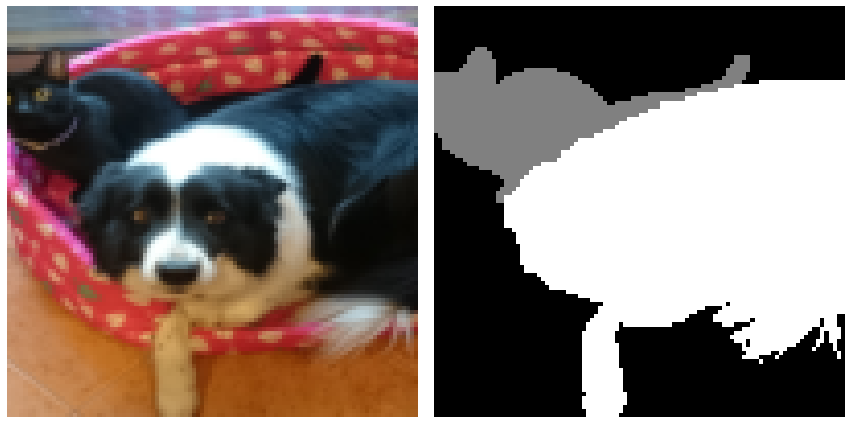

In [35]:
random_res_crop_paired = p_tr.RandomResizedCrop(100, (0.5, 0.6), (2./3., 3./4.))
random_resized_cropped_pair = random_res_crop_paired(image, new_gdt)
imshow_pair(*random_resized_cropped_pair)

<a id='five_crop'></a>

## `FiveCrop()`

In [36]:
size = 250
five_cropper = p_tr.FiveCrop(size)
im_l, gt_l = five_cropper(image, new_gdt)

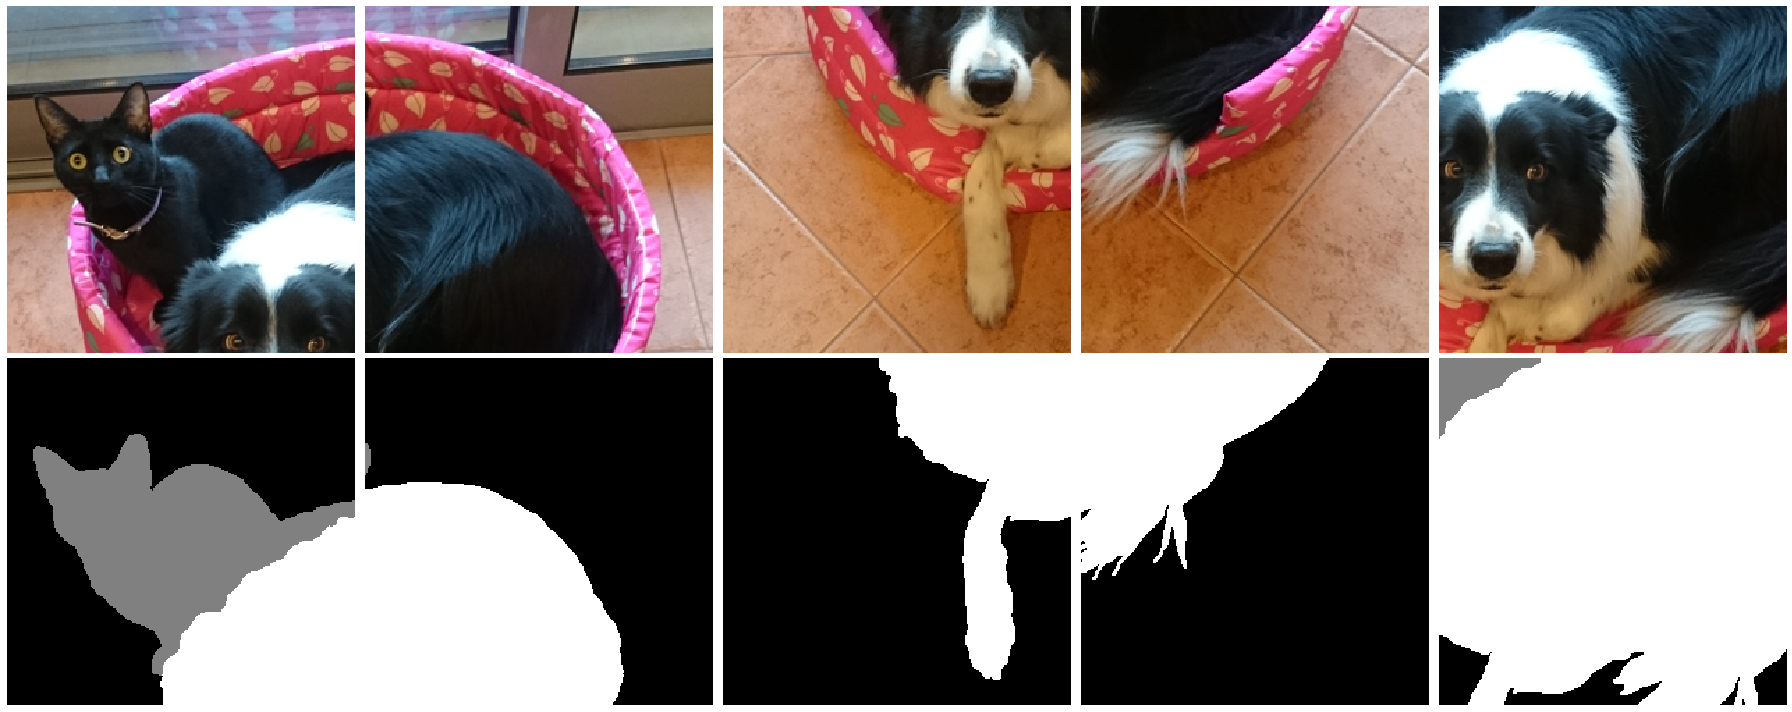

In [37]:
imshow_pair_list(im_l, gt_l)

<a id='ten_crop'></a>

## `TenCrop()`

In [38]:
size = 250
ten_cropper = p_tr.TenCrop(size)
im_l, gt_l = ten_cropper(image, new_gdt)

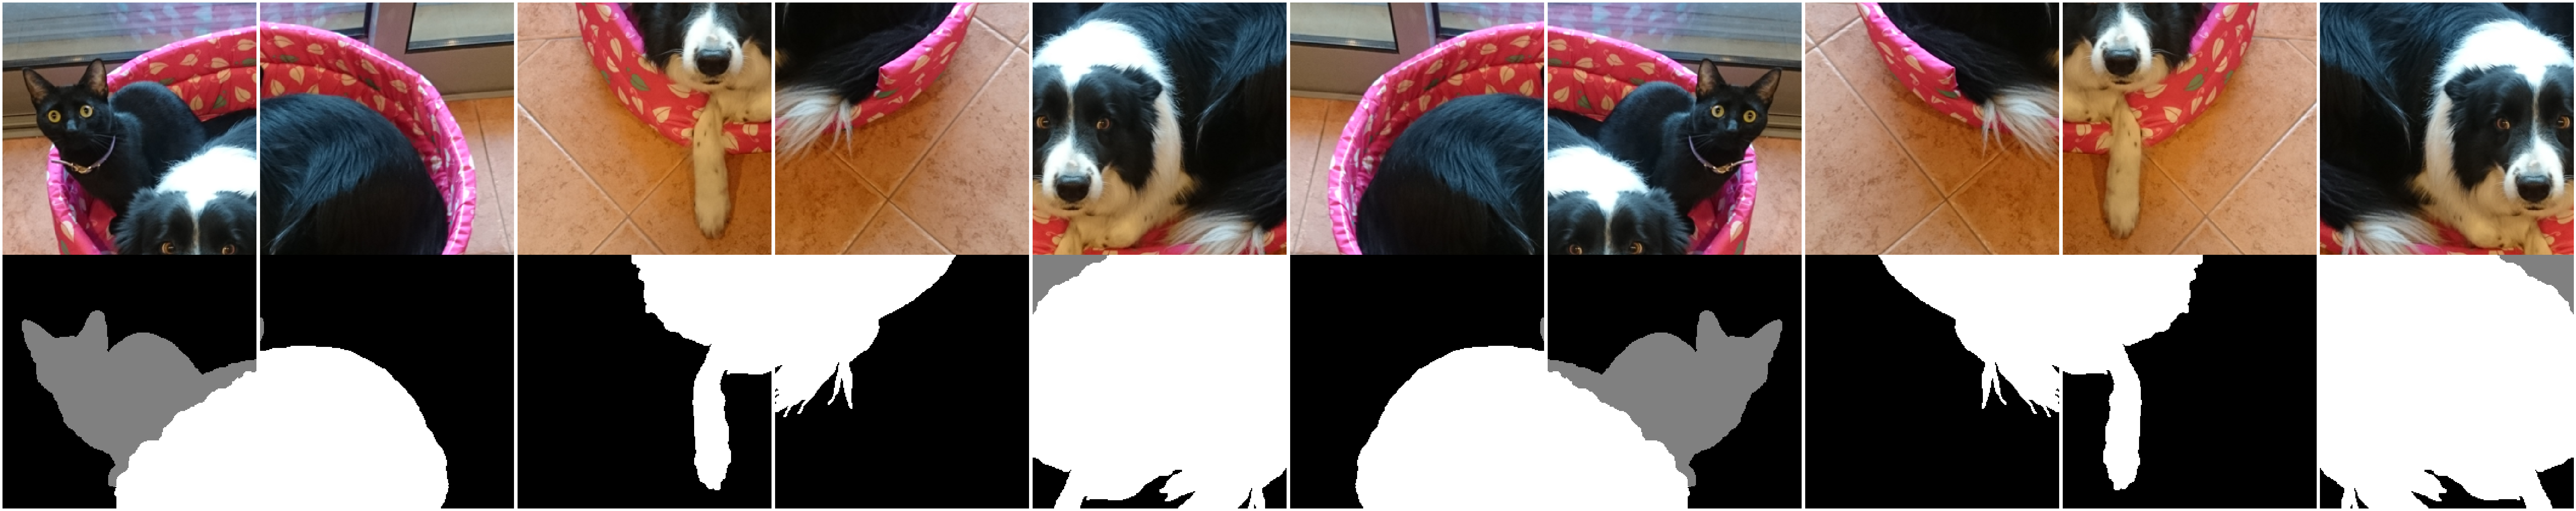

In [39]:
imshow_pair_list(im_l, gt_l)

<a id='random_rotation'></a>

## `RandomRotation()`

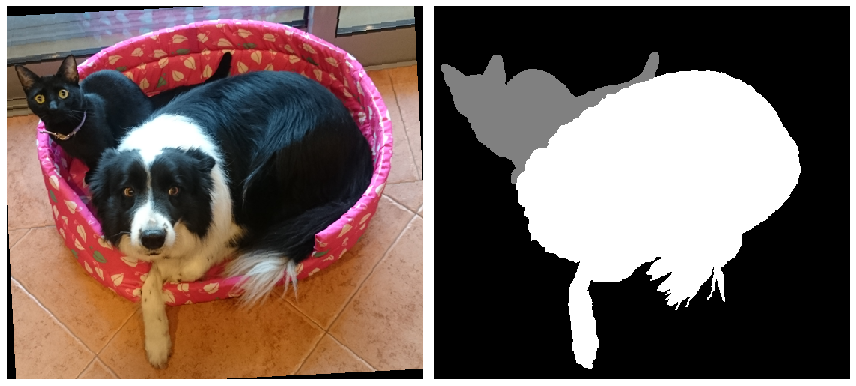

In [46]:
degrees = (0,180)
rotate_paired = p_tr.RandomRotation(degrees)
rotated_pair = rotate_paired(image, new_gdt)
imshow_pair(*rotated_pair)

<a id='random_affine'></a>

## `RandomAffine()`

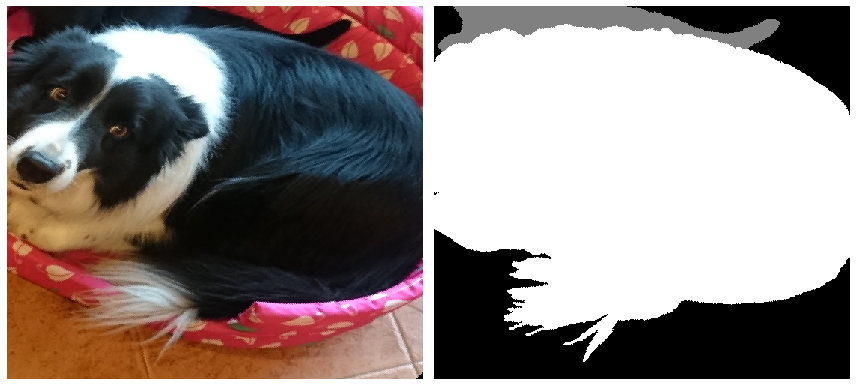

In [66]:
degrees=(0.,180.)
translate=(0.2, 0.23)
scale=(1.5, 2.)
shear=(10., 20.)
affine_paired = p_tr.RandomAffine(degrees, translate, scale, shear)
affine_pair = affine_paired(image, new_gdt)
imshow_pair(*affine_pair)

<a id='compose'></a>

# `Compose`:

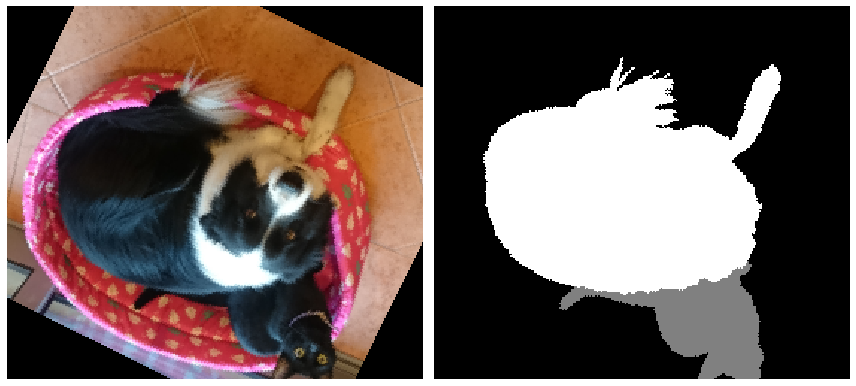

In [77]:
degrees=(90,180)
composed_paired_tr = p_tr.Compose([p_tr.Resize(250), p_tr.RandomRotation(degrees)])
image_tr, gdt_tr = composed_paired_tr(image, new_gdt)
imshow_pair(image_tr, gdt_tr)

<a id='to_tensor'></a>

# `ToTensor`:

In [78]:
tensorizer_paired = p_tr.ToTensor()
img_tnsr, gdt_tnsr = tensorizer_paired(image, new_gdt)
type(img_tnsr), type(gdt_tnsr)

(torch.Tensor, torch.Tensor)

Note that the extended `ToTensor()` implementation already assumes you provide a grayscale target with labels encoded as integers, and it will return a `Long` tensor properly formatted:

In [79]:
gdt_tnsr.dtype, gdt_tnsr.shape, np.unique(gdt_tnsr)

(torch.int64, torch.Size([498, 556]), array([0, 1, 2]))

<a id='to_PILimage'></a>

# `ToPILImage`:

In [80]:
topil_paired = p_tr.ToPILImage()
img_2, gdt_2 = topil_paired(img_tnsr, gdt_tnsr)
type(img_2), type(gdt_2)

(PIL.Image.Image, PIL.Image.Image)

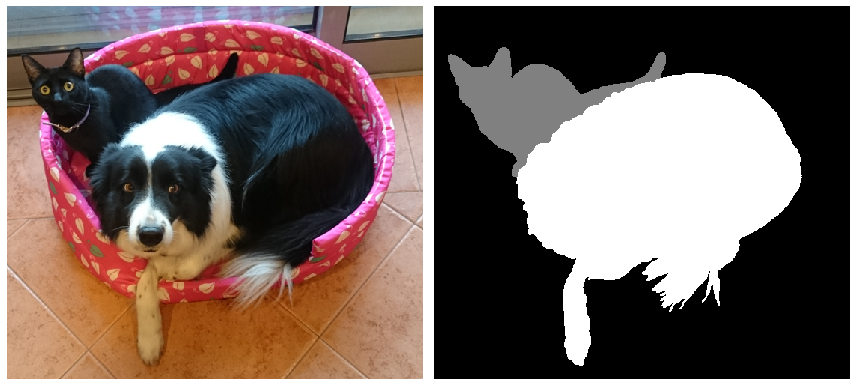

In [81]:
imshow_pair(img_2, gdt_2)

<a id='non_paired_transforms'></a>

# Non-pairable transforms:
The transforms below are not intended to be applied to the ground-truth image, and hence they would raise an exception if you attempt to pass a pair (image, ground-truth). However, they can be succesfully applied if the input is a single image.

In this extended version, these transforms will return the modified version of the image, but the target (second argument) will remain the same.
<a id='normalize'></a>

<a id='color_jitter'></a>

## `ColorJitter()`

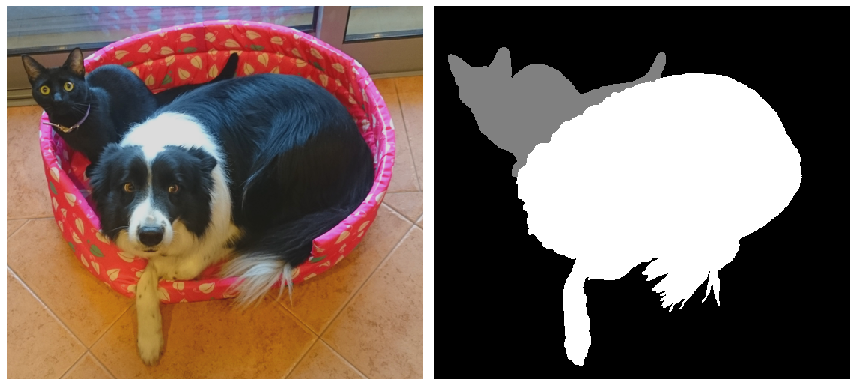

In [82]:
brightness, contrast, saturation, hue = 0.5, 0.5, 0.5, 0.05
jitter_paired = p_tr.ColorJitter(brightness, contrast, saturation, hue)
jittered_pair = jitter_paired(image, new_gdt)
imshow_pair(*jittered_pair)

<a id='grayscale'></a>

## `Grayscale()`

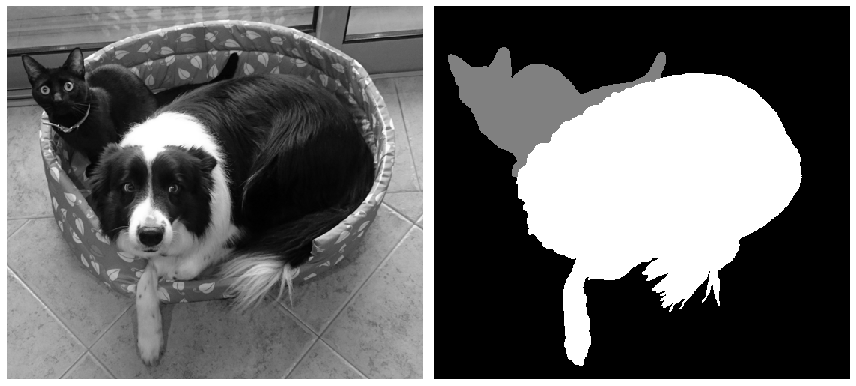

In [83]:
n_channels = 1
grayscale_paired = p_tr.Grayscale(n_channels)
grayscale_pair = grayscale_paired(image, new_gdt)
imshow_pair(*grayscale_pair)

<a id='random_grayscale'></a>

## `RandomGrayscale()`

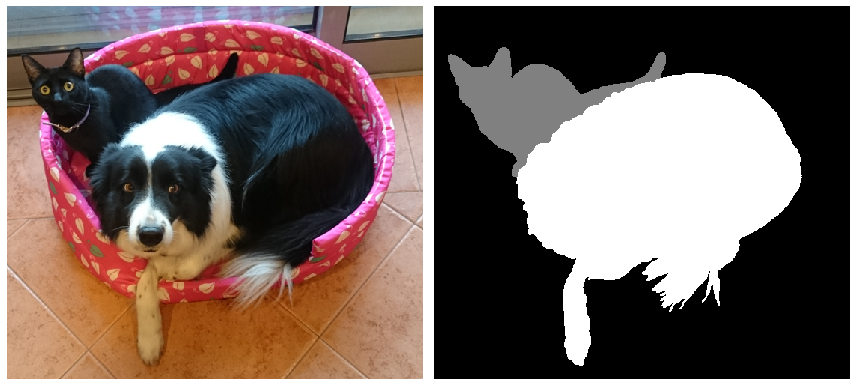

In [84]:
gray_prob = 0.5
rand_grayscale_paired = p_tr.RandomGrayscale(gray_prob)
rand_grayscale_pair = rand_grayscale_paired(image, new_gdt)
imshow_pair(*rand_grayscale_pair)

<a id='lambda'></a>

## `Lambda()` 
In this extension, we leave `Lambda` as an operation that returns the target image unaltered

In [85]:
from PIL import ImageFilter

def blur(img):
    return img.filter(ImageFilter.GaussianBlur(radius=5))

In [86]:
blur_tr = p_tr.Lambda(lambda x: blur(x))

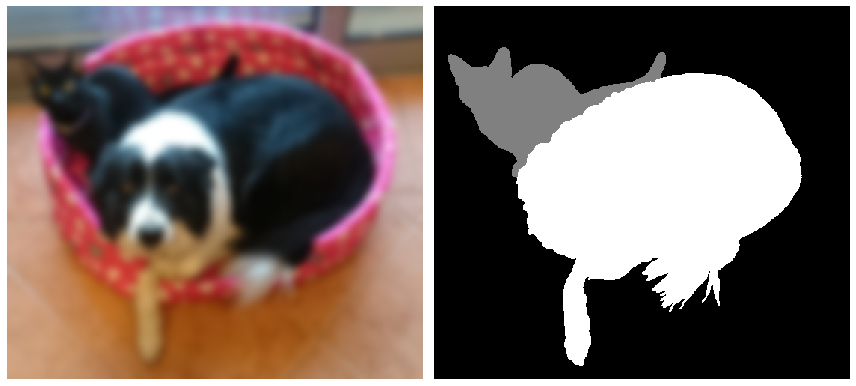

In [87]:
blurred_pair = blur_tr(image, new_gdt)
imshow_pair(*blurred_pair)

<a id='on_tensors'></a>

# Operations on Tensors
A few `torchvision` operations are to be performed on tensors instead of on `PIL` images, so we first need to  convert our example images using `ToTensor()`.

As above, the three operations we can do on tensors (`Normalize`, `LinearTransformation`, `RandomErasing`) are typically not intended to be applied to the target. Therefore, the behavior of the extended transformations is to only modify the image tensor but not the target tensor. 
<a id='normalize'></a>

## `Normalize()`

To understand how this works, let us first observe the behavior of `Normalize` for a single image:

In [88]:
import torchvision.transforms as tr

mean = 0.485, 0.456, 0.406
std = 0.229, 0.224, 0.225

tensorizer_single = tr.ToTensor()
normalizer_single = tr.Normalize(mean, std)

Check mean/std of each channel **before** normalization:

In [89]:
image_tensor = tensorizer_single(image)
print(image_tensor.mean(dim=[1,2]))
print(image_tensor.std(dim=[1,2]))

tensor([0.5257, 0.3744, 0.3317])
tensor([0.2810, 0.2236, 0.2386])


Check mean/std of each channel **after** normalization:

In [90]:
normalized_single = normalizer_single(image_tensor)
print(normalized_single.mean(dim=[1,2]))
print(normalized_single.std(dim=[1,2]))

tensor([ 0.1776, -0.3641, -0.3302])
tensor([1.2270, 0.9983, 1.0606])


In the case of paired `Normalize`, we pass a list of two tensors , and only the first one should be normalized:

In [91]:
normalizer_paired = p_tr.Normalize(mean, std)

First convert to tensor both images:

In [92]:
tensorizer_paired = p_tr.ToTensor()


image_tensor, gdt_tensor = tensorizer_paired(image, new_gdt)

Check mean/std of each channel of `image_tensor` and `gdt_tensor` **before** normalization:

In [95]:
print(image_tensor.mean(dim=[1,2]))
print(image_tensor.std(dim=[1,2]))
print('---------')
print(gdt_tensor.float().mean())
print(gdt_tensor.float().std())

tensor([0.5257, 0.3744, 0.3317])
tensor([0.2810, 0.2236, 0.2386])
---------
tensor(0.6636)
tensor(0.9076)


Now normalize the pair of tensors:

In [96]:
image_tensor_norm, gdt_tensor_norm = normalizer_paired(image_tensor, gdt_tensor)

Check mean/std of each channel of `image_tensor` and `gdt_tensor` **before** normalization:

In [97]:
print(image_tensor_norm.mean(dim=[1,2]))
print(image_tensor_norm.std(dim=[1,2]))
print('---------')
print(gdt_tensor_norm.float().mean())
print(gdt_tensor_norm.float().std())

tensor([ 0.1776, -0.3641, -0.3302])
tensor([1.2270, 0.9983, 1.0606])
---------
tensor(0.6636)
tensor(0.9076)


As expected, mean/std of `gdt_tensor` are unmodified.

<a id='random_erasing'></a>

## `RandomErasing()`

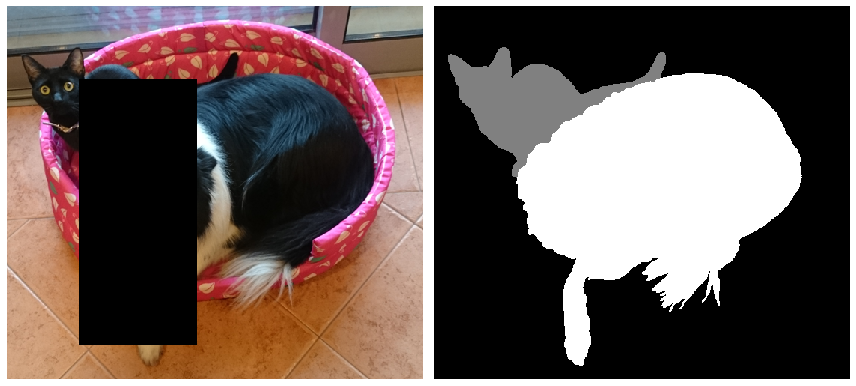

In [101]:
erase_prob = 1
rand_erase_paired = p_tr.RandomErasing(erase_prob)
tensorize_paired = p_tr.ToTensor()
to_pil_im_paired = p_tr.ToPILImage()

rand_erase_pair = rand_erase_paired(*tensorize_paired(image, new_gdt))
imshow_pair(*to_pil_im_paired(*rand_erase_pair))

<a id='linear_transformation'></a>

## `LinearTransformation()`
`LinearTransformation` will be applied to the input image but the target image will be left unmodified.

<a id='example'></a>

# Example: Building a Dataloader with Paired Transforms
<a id='dataset'></a>

## Dataset:
Let us first build a `pytorch` dataset holding only an image and its related ground-truth. Note that we are applying the color-to-labels transform just after reading the target image below. The values associated to each label are passed to the constructor of the dataset.

In [102]:
label_values = np.unique(gdt.convert('L')); label_values

array([ 29,  91, 218], dtype=uint8)

In [103]:
label_values = [29, 91, 218] # these values need to be found out in advance

In [105]:
new_gdt = encode_labels(gdt, label_values)
np.unique(new_gdt)

array([0, 1, 2], dtype=uint8)

In [106]:
from torch.utils.data.dataset import Dataset

class data(Dataset):
    def __init__(self, root_dir='images/', transforms = None, label_values=None):
        self.root_dir = root_dir
        self.im_names = ['luppo_and_more.png']
        self.gt_names = ['labels.png']
        self.transforms = transforms
        self.label_values = label_values

    def label_encoding(self, gdt):
        gdt_gray = np.array(gdt.convert('L'))
        classes = np.arange(len(self.label_values))
        for i in classes:
            gdt_gray[gdt_gray==self.label_values[i]]=classes[i]
        return Image.fromarray(gdt_gray)

    def __getitem__(self, index):
        im_name = os.path.join(self.root_dir, self.im_names[index])
        gt_name = os.path.join(self.root_dir, self.gt_names[index]) 
                
        image = Image.open(im_name) 
        gt = self.label_encoding(Image.open(gt_name)) # convert color labels to integers

        # If transforms are provided
        if self.transforms is not None:
            image, gt = self.transforms(image, gt)
                       
        return image, gt

    def __len__(self):
        return len(self.im_names)

Now we can define a series of paired transforms to be applied to this pair of images before retrieving them from the dataset:

In [107]:
# parameters defining the different transforms
rotate_range = 30
crop_size = 400
brightness, contrast, saturation, hue = 0.5, 0.5, 0.5, 0.05

Now we define the transforms. Note that we do this using the transforms from the `paired_transforms` module, rather than from `torchvision.transforms`.

In [108]:
# paired transforms
rotate = p_tr.RandomRotation(rotate_range)
random_crop = p_tr.RandomCrop(crop_size)
h_flip = p_tr.RandomHorizontalFlip()
jitter = p_tr.ColorJitter(brightness, contrast, saturation, hue)

Finally, we compose all the defined transforms into a list. Note that `Compose` comes also from the `paired_transforms` module, since it is meant to compose paired transformations.

In [109]:
# composed paired transforms
transforms = p_tr.Compose([jitter, random_crop, rotate, h_flip])

The dataset can now be instantiated. 

In [110]:
dataset = data(root_dir='images/', transforms=transforms, label_values=label_values)

Since we are not passing a `ToTensor` transform, we get back `numpy` arrays that can be inspected (plotted) without additional operations:

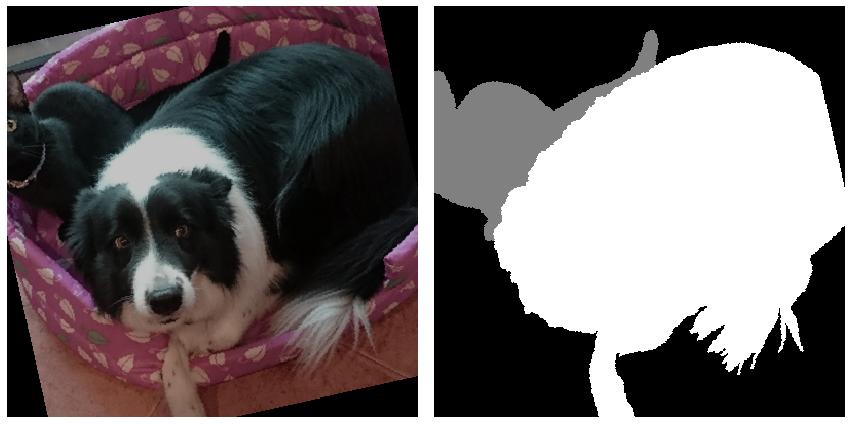

In [111]:
img, gt = dataset[0]
imshow_pair(img, gt)

<a id='dataloader'></a>

## DataLoader:
Let us build a dataloader that we can use for training a neural network. The dataset is the same as above, but the transforms now include a `ToTensor` operation, which also comes from the `paired_transforms` module, and a `RandomErasing()` transform.

In [112]:
transforms = p_tr.Compose([jitter, random_crop, rotate, h_flip, p_tr.ToTensor(), p_tr.RandomErasing()])
paired_dataset = data('images/', transforms=transforms, label_values=label_values)

With this dataset, we can instantiate a dataloader:

In [113]:
from torch.utils.data import DataLoader

paired_loader = DataLoader(dataset=paired_dataset)

To check if everything works as expected, let us get a batch out of it and inpsect its size:

In [121]:
batch_index, (im_batch, labels_batch) = next(enumerate(paired_loader))
batch_index, im_batch.size(), labels_batch.size()

(0, torch.Size([1, 3, 400, 400]), torch.Size([1, 400, 400]))

In this case, to visually inspect the result, we first need to transform these two tensors into PIL images. This can be done with the `ToPILImage` class; and if you use the extended version from `paired_transforms`, you can pass directly a tuple of tensors to it:

In [122]:
to_pil_im = p_tr.ToPILImage()

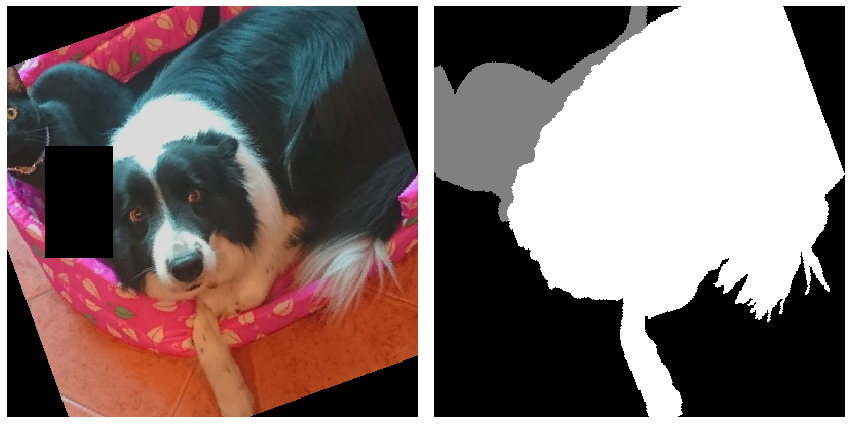

In [123]:
imshow_pair(*to_pil_im(im_batch[0], labels_batch[0]))